In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:

pop_df=pd.read_csv(r'C:\Users\Yasaman\Downloads\World_bank_population.csv',skiprows=3)
pop_df['Country Code']=pop_df['Country Code'].apply(lambda x: x.lower())
possible_countries=pop_df.query(" `2019` >=1000000")['Country Code'].values

excluded_iso3_codes = [
    "IRL",  # Ireland
    "SSD",  # South Sudan
    "SDN",  # Sudan
    "COG",  # Republic of the Congo
    "COD",  # Democratic Republic of the Congo
    "GIN",  # Guinea
    "GNB",  # Guinea-Bissau
    "GNQ",  # Equatorial Guinea
    "PNG",  # Papua New Guinea
    "XKX",  # Kosovo (unofficial)
    "MNE",  # Montenegro
    "SRB",  # Serbia
    "TLS",   # Timor-Leste
    "GEO", #Georgia
    'SWZ', 
    'PRK', #North Korea
]
excluded_iso3_codes=[c.lower() for c in excluded_iso3_codes]


possible_iso=list(set(possible_countries)-set(excluded_iso3_codes))

In [3]:

df = pd.read_csv(r"C:\Users\Yasaman\Downloads\Attention-fractional counting.csv")
df.rename(columns={'aggregated_value': 'count', 'country': 'Mention_country', 'affiliation_country': 'Aff_country'}, inplace=True)
df=df[(df['Mention_country'].isin(possible_iso))&(df['Aff_country'].isin(possible_iso))]
df = df[df['year'].isin(np.arange(2002, 2020))]
Country_list={'Egypt':'EGY', 'Tunisia':'TUN','Libya':'LBY','Syria':'SYR','Yemen':'YEM','Bahrain':'BHR','Jordan':'JOR','Kuwait':'KWT','Morocco':'MAR','Oman':'OMN'}
rev_Country_list={Country_list[key]: key for key in Country_list}
abbr=[country.lower() for country in Country_list.values()]
physical_sciences=['MATH', 'ENGI', 'PHYS', 'COMP', 'MUL']
df=df[~df['subjarea'].isin(physical_sciences)]
df=df.groupby(['year', 'Mention_country'])['count'].sum().reset_index()


data=pd.read_csv(r"C:\Users\Yasaman\Downloads\scopus_2024_V1_scholarlymigration_country_enriched.csv")
data=data[data['year'].isin(np.arange(2002, 2020))]
data=data[['iso3code', 'incomelevel', 'gdp_per_capita', 'year', 'population', 'region', 'padded_population_of_researchers']].dropna()
data.rename(columns={'iso3code':'Mention_country'}, inplace=True)
data['Mention_country']=data['Mention_country'].apply(lambda x: x.lower())
df=df.merge(data, on=['Mention_country', 'year'], how='outer')
df=df[df['Mention_country'].isin(possible_iso)]


countries_to_remove=[]
for c  in df['Mention_country'].unique():
    if ((~df['count'].isna()) & (df['Mention_country'] == c)).sum()<15:
        countries_to_remove.append(c)
        print(c)

print(len(countries_to_remove))


# Define the required year range
required_years = list(range(2002, 2020))

# Get the unique countries
unique_countries = df["Mention_country"].unique()

# Create a complete DataFrame with all country-year combinations
full_data = []
for country in unique_countries:
    country_data = df[df["Mention_country"] == country]
    existing_years = set(country_data["year"])
    
    for year in required_years:
        if year in existing_years:
            row = country_data[country_data["year"] == year].iloc[0].to_dict()
        else:
            row = {
                "year": year,
                "Mention_country": country,
                "count": 0,
                "gdp_per_capita": np.nan,
                "population": np.nan,
                "region": country_data["region"].iloc[0] if not country_data.empty else np.nan,
            }
        full_data.append(row)

# Convert to DataFrame
df_complete = pd.DataFrame(full_data)

df_complete['treated']=df_complete['Mention_country'].isin(abbr).astype(int)
df_complete['treated_CW']=df_complete['Mention_country'].isin(['yem', 'lby', 'syr']).astype(int)
df_complete['treated_GO']=df_complete['Mention_country'].isin(['egy', 'tun']).astype(int)
df_complete['treated_GC']=df_complete['Mention_country'].isin(['omn', 'kwt', 'bhr', 'mar','jor']).astype(int)
df_complete['post']=df_complete['year'].apply(lambda x: 0 if x>=2002 and x<=2010 else 1 )
df_complete['count']=df_complete['count'].fillna(0)
df_complete['log_count']=np.log(df_complete['count']+1)

df_complete[['region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].ffill()
df_complete[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']] = df_complete.groupby('Mention_country')[[ 'region', 'gdp_per_capita', 'population','padded_population_of_researchers']].bfill()
df_complete['log_gdp']=np.log(df_complete['gdp_per_capita'])
df_complete['log_population']=np.log(df_complete['population'])
df_complete['log_Rpop']=np.log(df_complete['padded_population_of_researchers']+1)
df_complete=df_complete[df_complete['Mention_country'].isin(possible_iso)].reset_index(drop=True)


0


In [47]:
df_p=df_complete[df_complete['year']<2011].reset_index(drop=True)
df_p['time']=df_p['year']-2011

# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ time+treated * time +log_gdp+log_Rpop+log_population+ C(Mention_country)", data=df_p).fit(cov_type='cluster', cov_kwds={'groups': df_p['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     66.25
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           1.27e-35
Time:                        08:24:17   Log-Likelihood:                 700.89
No. Observations:                1305   AIC:                            -1102.
Df Residuals:                    1155   BIC:                            -325.7
Df Model:                         149                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 150, but rank is 5
  warnings.warn('covariance of constraints does not have full '


### Notice: Pre-parallel trend test is not significant at the target level so not an issue.

In [11]:
df_complete['treated:post']=df_complete['treated']*df_complete['post']
# Select the independent variables (excluding categorical variables handled by C())
independent_vars = df_complete[['treated', 'post', 'treated:post', 'log_gdp', 'log_Rpop', 'log_population']]
# Compute VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = independent_vars.columns
vif_data["VIF"] = [variance_inflation_factor(independent_vars.values, i) for i in range(len(independent_vars.columns))]
print(vif_data)


         Variable        VIF
0         treated   2.167785
1            post   2.217784
2    treated:post   2.152750
3         log_gdp  34.636307
4        log_Rpop  22.188497
5  log_population  24.858215


### Notice: The VIF for treated:post is not high, so safe to go:)

Text(0, 0.5, 'log Domestic attention')

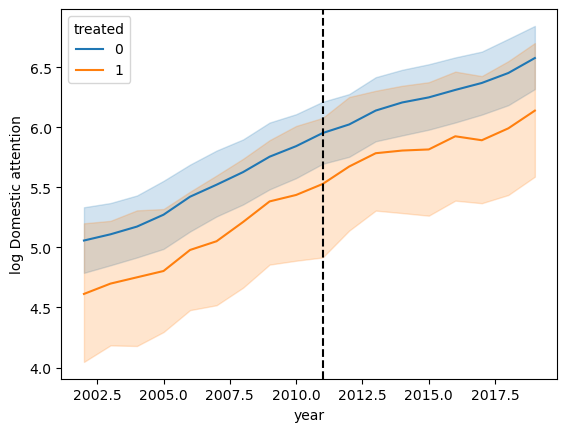

In [6]:
sns.lineplot(data=df_complete, x='year', y='log_count', hue='treated')
plt.axvline(2011, color='k', linestyle='--')
plt.ylabel('log Domestic attention')

### Trends for the world is stable and linear. There exists a pattern change before and after the arab spring visually. 

In [14]:
# Running the Difference-in-Differences regression
model = smf.ols("log_count ~ treated* post +log_gdp+log_Rpop+ log_population+C(Mention_country) + C(year)", data=df_complete).fit(cov_type='cluster', cov_kwds={'groups': df_complete['Mention_country']})
# Print summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_count   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     51.68
Date:                Mon, 17 Mar 2025   Prob (F-statistic):           2.07e-56
Time:                        08:59:58   Log-Likelihood:                 944.22
No. Observations:                2610   AIC:                            -1556.
Df Residuals:                    2444   BIC:                            -582.5
Df Model:                         165                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

c:\Users\Yasaman\anaconda3\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 167, but rank is 21
  warnings.warn('covariance of constraints does not have full '


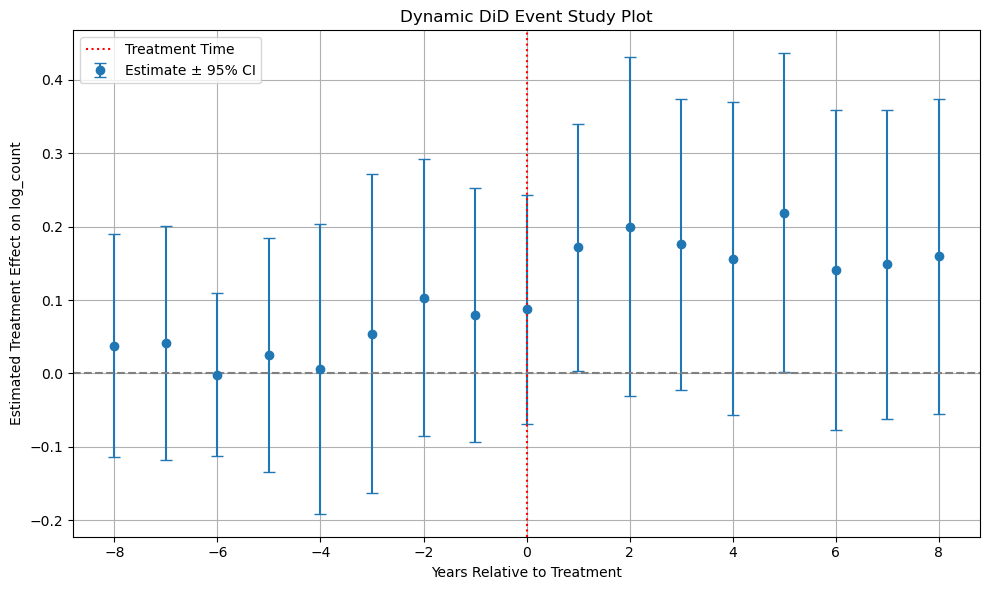

In [40]:
df_complete['relative_time'] = df_complete['year'] - 2011
df_complete['rel_time_cat'] = df_complete['relative_time'].astype('category')
model = smf.ols("log_count ~C(rel_time_cat)*treated + log_gdp + log_Rpop + log_population + C(Mention_country)", 
                data=df_complete).fit(cov_type='cluster', cov_kwds={'groups': df_complete['Mention_country']})
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get all parameter names, coefficients, and standard errors
params = model.params
bse = model.bse

# Filter for rel_time_cat coefficients (excluding the reference period)
rel_time_coefs = {}
rel_time_ses = {}

for param, coef in params.items():
    match = re.match(r"C\(rel_time_cat\)\[T\.(\-?\d+\.?\d*)\]", param)
    if match:
        rel_time = float(match.group(1))
        rel_time_coefs[rel_time] = coef
        rel_time_ses[rel_time] = bse[param]


# Sort by relative time
rel_times = sorted(rel_time_coefs.keys())
coefs = [rel_time_coefs[t] for t in rel_times]
ses = [rel_time_ses[t] for t in rel_times]
plt.figure(figsize=(10, 6))
plt.errorbar(rel_times, coefs, yerr=[1.96*s for s in ses], fmt='o', capsize=4, label='Estimate ± 95% CI')

plt.axhline(0, linestyle='--', color='gray')
plt.axvline(0, linestyle=':', color='red', label='Treatment Time')

plt.title("Dynamic DiD Event Study Plot")
plt.xlabel("Years Relative to Treatment")
plt.ylabel("Estimated Treatment Effect on log_count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [36]:
rel_time_coefs

{-8.0: 0.038006049301447575,
 -7.0: 0.04143457669334616,
 -6.0: -0.0015471475356663156,
 -5.0: 0.024993977132940923,
 -4.0: 0.006416958151726271,
 -3.0: 0.05445490649801199,
 -2.0: 0.10346556020151576,
 -1.0: 0.07969231175354605,
 0.0: 0.08776386555356097,
 1.0: 0.17174076394846227,
 2.0: 0.2002014771049634,
 3.0: 0.17612709774972057,
 4.0: 0.15668850450717697,
 5.0: 0.21917577670384336,
 6.0: 0.14067744879605515,
 7.0: 0.14852231896821283,
 8.0: 0.15977583509638527}